# 📚 5.2修成正果篇-神经风格迁移

         ✅能今天做好的事就不要等到明天。以梦为马，学习趁年华.

----------------------------------------------------------------------------------------------------------------

     神经风格迁移(Neural Style Transfer)是将一幅图片的内容和另一幅艺术图片的风格结合，生成一张艺术化的图片的过程。输入是一张内容图和一张风格图，输出是风格化的结果。这是通过优化输出图像以匹配内容图像的内容统计数据和风格参考图像的风格统计数据来实现的。

<img src="https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/forum/161699945662599581616999450805.png"/>

内容图选取这张小狗的照片和，风图选取的Wassily Kandinsky 的作品 7。


更多的风格迁移风格：左1图片为内容图片，左下为风格图，右为输出图片。

<img src="https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/forum/161699959769871761616999594506.png"/>

# 一、本节目标
       

 本节演示了原始的风格迁移算法，目前已经有好的方法可以直接 生成风格图片，
 
 TensorFlow Hub 和 TensorFlow Lite 中提供了预训练的任意图像风格化模块。
 
 知道什么是风格迁移，了解其中的模型，算法，知道深度学习的每个步骤进行对应。

# 二、实战

## 2.1 数据 获取

In [28]:
import tensorflow as tf

In [29]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [30]:
#因为我们调用的是tensorflow已经训练好的参数，所以在tensorflow_hub里面所以我们就要下载tensorflow_hub
!pip install tensorflow_hub --user

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


张量的数据类型转换成 PIL可以 展示的PIL格式

In [31]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

进行可视化

In [32]:
#定义一个加载图像的函数，并将其最大尺寸限制为 512 像素。
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [33]:
#功能：图片展示 ，创建一个简单的函数来显示图像
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

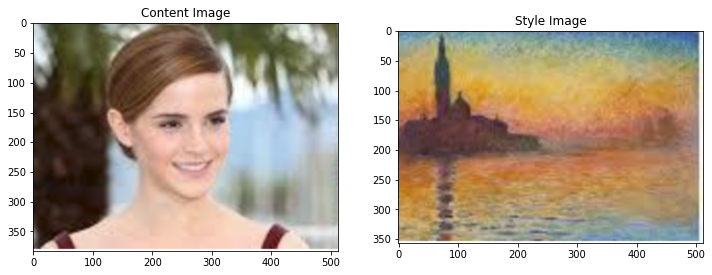

In [34]:
#可以上传两张自己的图片，一张风格图片content_image，一张内容图片style_image，
#点击左边栏的upload files进行上传，改load_img('5-2/2.png')中自己的路径
content_image = load_img('5-2/2.png')
style_image = load_img('5-2/1.png')
#显示查看
plt.subplot(1, 2, 1)
imshow(content_image1, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image1, 'Style Image')

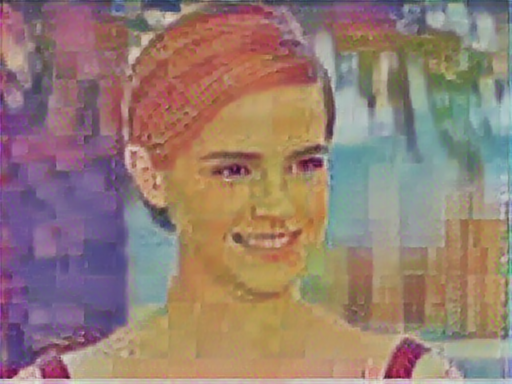

In [35]:
#使用 TF-Hub 进行快速风格迁移
import tensorflow_hub as hub
#下载tensorflow已经训练好的参数
hub_module = hub.load('https://hub.tensorflow.google.cn/google/magenta/arbitrary-image-stylization-v1-256/1')
#讲内容图和风格图送入模型参数中进行预测
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
#可视化出图片的结果
tensor_to_image(stylized_image)

## 2.2 定义内容和风格的表示

  使用模型的中间层来获取图像的内容和风格表示。 
  
  从网络的输入层开始，前几个层的激励响应表示边缘和纹理等低级 feature (特征)。
  
  随着层数加深，最后几层代表更高级的 feature (特征)——实体的部分，如轮子或眼睛。
  
  在此教程中，我们使用的是 VGG19 网络结构，这是一个已经预训练好的图像分类网络。 这些中间层是从图像中定义内容和风格的表示所必需的。
  
  对于一个输入图像，我们尝试匹配这些中间层的相应风格和内容目标的表示。

In [10]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
##keras提供了VGG19在ImageNet上的预训练权重模型文件，其他可用的模型还有VGG16、Xception、ResNet50、InceptionV3 4个
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
##include_top: 是否包含最后的3个全连接层.定义为‘imagenet’，表示加载在imagenet数据库上训练的预训练权重，定义为None则不加载权重，参数随机初始化
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 16521s 29us/step


TensorShape([1, 1000])

In [11]:
#预测前五个
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 1s 17us/step


[('Labrador_retriever', 0.4931726),
 ('golden_retriever', 0.23665185),
 ('kuvasz', 0.036357313),
 ('Chesapeake_Bay_retriever', 0.024182772),
 ('Greater_Swiss_Mountain_dog', 0.018646035)]

# 三、 课后作业

1 自己试着理解理解神经风格迁移的思维过程 ，动手实践一下。